This notebook studies the  online reconstruction of cartesian MRI problem.
We will be using monocoil data. The aim of online reconstruction is speed,
without compromising the quality of reconstruction.

In [1]:
%matplotlib inline
DATA_DIR = "data/"
N_JOBS = 1
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from utils import implot, load_data

from numba import jit,njit, objmode, prange

(16, 640, 320) complex128
(320, 320) float32
file_brain_AXFLAIR_200_6002462.h5
1


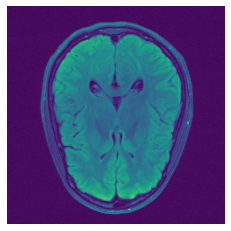

In [2]:
_, real_img, mask_loc, final_mask = load_data(DATA_DIR,1)

implot(real_img)

In [3]:
## Fourier transform

In [4]:
@njit(parallel=True)
def fft15_dft_mask(img,kshift):
    shape = np.shape(img)
    k = (kshift + shape[1]//2) % shape[1]
    y = np.zeros(shape[1], dtype=np.complex128)
    cos = np.cos(2 * np.pi * k / shape[1])
    sin = np.sin(2 * np.pi * k / shape[1])
    exp_k = cos - 1j * sin
    for j in prange(shape[0]):
        u = 1/np.sqrt(shape[1])
        for i in prange(shape[1]):
            y[j] += img[j,i] * u
            u *= exp_k
    with objmode(out='complex128[:]'):
         out = sp.fft.fft(y,norm="ortho")
    return out

### Scipy FFT and slice

In [5]:
%%timeit -n 100

k_ref = sp.fft.ifftshift(sp.fft.fft2(sp.fft.fftshift(real_img),norm="ortho"))[:,160]


1.2 ms ± 86.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### FFT1.5D python

In [6]:
%%time
# first time, jit compiling
_ = sp.fft.ifftshift(fft15_dft_mask(sp.fft.fftshift(real_img),160))

CPU times: user 1.03 s, sys: 1.16 s, total: 2.2 s
Wall time: 810 ms


### FFT1.5D numba

In [7]:
%%timeit -n 100
# GO FAST
k_g= sp.fft.ifftshift(fft15_dft_mask(sp.fft.fftshift(real_img),160))


212 µs ± 49.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


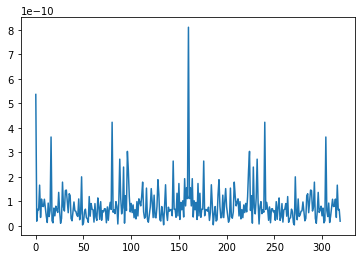

In [8]:
k_ref = sp.fft.ifftshift(sp.fft.fft2(sp.fft.fftshift(real_img),norm="ortho"))[:,160]
k_g= sp.fft.ifftshift(fft15_dft_mask(sp.fft.fftshift(real_img),160))

plt.plot(abs(k_ref-k_g))

## Inverse fourier transform

In [9]:
@njit(parallel=True)
def idft_mask(y:np.array, kshift:int, dim:int):
    k = (kshift + y.size//2) % y.size
    img = np.zeros((dim,y.size),dtype=np.complex128)
    cos = np.cos(2 * np.pi * k / y.size)
    sin = np.sin(2 * np.pi * k / y.size)
    exp_k = cos + 1j * sin
    #with objmode(out='complex128[:]'):

    for j in prange(y.size):
        u = 1/np.sqrt(y.size)
        for i in prange(dim):
            img[j,i] = y[j] * u
            u *= exp_k
    return img

def ifft15(y:np.array, kshift:int, dim:int):
    return idft_mask(sp.fft.ifft(y,norm="ortho"),kshift,dim)

In [10]:
k_ref = sp.fft.ifftshift(sp.fft.fft2(sp.fft.fftshift(real_img),norm="ortho"))[:,160]
k_g= sp.fft.ifftshift(fft15_dft_mask(sp.fft.fftshift(real_img),160))

### IFFT2

In [11]:
%%timeit -n 100
k_ref_mask = np.zeros((320,320),dtype=complex)
k_ref_mask[:,160] = k_ref
img_ref = sp.fft.fftshift(sp.fft.ifft2(sp.fft.ifftshift(k_ref_mask)))

3.21 ms ± 272 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### IFFT1.5D python

In [12]:
%%time
_ = sp.fft.fftshift(ifft15(sp.fft.ifftshift(k_ref),160,320))

CPU times: user 484 ms, sys: 19.8 ms, total: 504 ms
Wall time: 497 ms


### IFFT1.5D jit

In [13]:
%%timeit -n 100
 sp.fft.fftshift(ifft15(sp.fft.ifftshift(k_ref),160,320))

744 µs ± 110 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
k_ref_mask = np.zeros((320,320),dtype=complex)
k_ref_mask[:,160] = k_ref

img_ref = sp.fft.fftshift(sp.fft.ifft2(sp.fft.ifftshift(k_ref_mask),norm="ortho"))
img_g =  sp.fft.fftshift(ifft15(sp.fft.ifftshift(k_g),160,320))

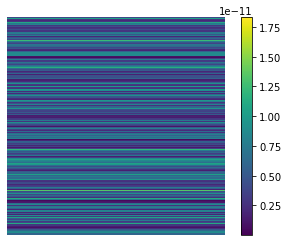

In [15]:
implot(img_g-img_ref,colorbar=True)

## Self adjoint operator

(16, 640, 320) complex128
(320, 320) float32
file_brain_AXFLAIR_200_6002462.h5
1


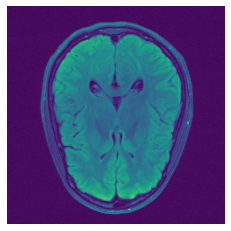

In [16]:
_, real_img, mask_loc, final_mask = load_data(DATA_DIR,1)

implot(real_img)

def selfadj_fft2(img, k):
    k_ref = sp.fft.ifftshift(sp.fft.fft2(img,norm="ortho"))[:,k]
    k_ref_mask = np.zeros_like(img,dtype=np.complex128)
    k_ref_mask[:,k] = k_ref
    return sp.fft.ifft2(sp.fft.ifftshift(k_ref_mask),norm="ortho")

def selfadj_fft15_sp(img,k):
    k_g= sp.fft.ifftshift(fft15_dft_mask(sp.fft.fftshift(img),k))
    return  sp.fft.fftshift(ifft15(sp.fft.ifftshift(k_g),k,img.shape[0]))

@njit(parallel=True)
def selfadj_fft15(img,kshift):
    shape = np.shape(img)
    img_out = np.zeros_like(img,dtype=np.complex128)
    k = (kshift + shape[1]//2) % shape[1]
    y = 0.j
    cos = np.cos(2 * np.pi * k / shape[1])
    sin = np.sin(2 * np.pi * k / shape[1])
    exp_f = cos - 1j * sin
    exp_b = cos + 1j * sin
    for j in prange(shape[0]):
        y = 0.j
        u = 1/np.sqrt(shape[1])
        for i in prange(shape[1]):
            y += img[j,i] * u
            u *= exp_f
        u = 1/np.sqrt(shape[1])
        for i in prange(shape[1]):
            img_out[j,i] = y * u
            u *= exp_b
    return img_out

In [17]:
%%timeit -n 100
_  = sp.fft.fftshift(selfadj_fft2(sp.fft.fftshift(real_img),160))

5.43 ms ± 207 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
%%timeit -n 100
_  = sp.fft.fftshift(selfadj_fft15_sp(sp.fft.fftshift(real_img),160))

2.09 ms ± 206 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
%%time
_  = sp.fft.fftshift(selfadj_fft15(sp.fft.fftshift(real_img),160))

CPU times: user 440 ms, sys: 1.26 ms, total: 441 ms
Wall time: 438 ms


In [20]:
%%timeit -n 100
_  = sp.fft.fftshift(selfadj_fft15(sp.fft.fftshift(real_img),160))

1.13 ms ± 187 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


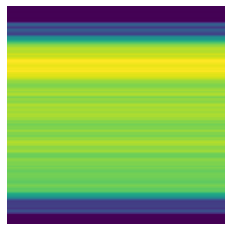

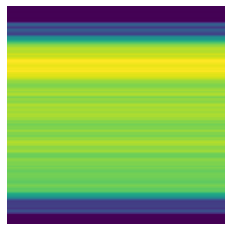

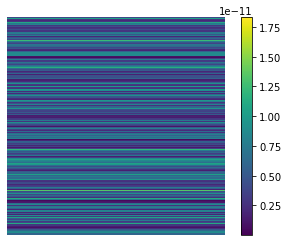

In [21]:
img_ref = sp.fft.fftshift(selfadj_fft2(sp.fft.fftshift(real_img),160))
img_g = sp.fft.fftshift(selfadj_fft15(sp.fft.fftshift(real_img),160))
implot(img_ref)
implot(img_g)
implot(abs(img_ref-img_g),colorbar=True)

## How does it scale
### Forward operator

In [22]:
import time
sizes = [32,64,128,256,512,1024]
times1 = np.zeros((len(sizes),2))
for n in range(len(sizes)):
    ta = 0
    tb = 0
    for k in range(5):
        real_img = np.random.random((int(sizes[n]),int(sizes[n])))
        ts = time.perf_counter()
        _ = sp.fft.ifftshift(sp.fft.fft2(sp.fft.fftshift(real_img),norm="ortho"))[:,sizes[n]//2]
        ti = time.perf_counter()
        _ = sp.fft.ifftshift(fft15_dft_mask(sp.fft.fftshift(real_img),sizes[n]//2))
        tf = time.perf_counter()
        ta += ti-ts
        tb += tf-ti
    times1[n,0] = ta/5
    times1[n,1] = tb/5


Text(0, 0.5, 'time')

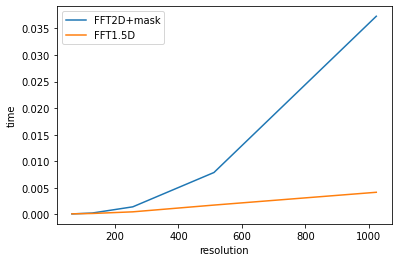

In [23]:
plt.plot(sizes[1:],times1[1:,0],label="FFT2D+mask")
plt.plot(sizes[1:],times1[1:,1],label="FFT1.5D")
plt.legend()
plt.xlabel('resolution')
plt.ylabel('time')

### Backward operator

In [24]:
import time
sizes = [32,64,128,256,512,1024]
times = np.zeros((len(sizes),2))
for n in range(len(sizes)):
    ta = 0
    tb = 0
    for k in range(5):
        k_ref = np.random.random(sizes[n])
        ts = time.perf_counter()
        k_ref_mask = np.zeros((sizes[n],sizes[n]))
        k_ref_mask[:,sizes[n]//2] = k_ref
        _ = sp.fft.fftshift(sp.fft.ifft2(sp.fft.ifftshift(k_ref_mask)))
        ti = time.perf_counter()
        _ = sp.fft.fftshift(ifft15(sp.fft.ifftshift(k_ref),sizes[n]//2,sizes[n]))
        tf = time.perf_counter()
        ta += ti-ts
        tb += tf-ti
    times[n,0] = ta/5
    times[n,1] = tb/5


Text(0, 0.5, 'time')

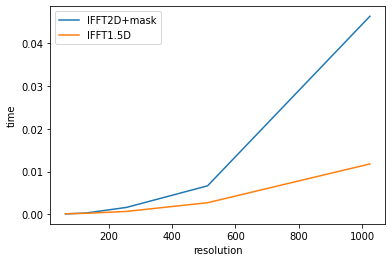

In [25]:
plt.plot(sizes[1:],times[1:,0],label="IFFT2D+mask")
plt.plot(sizes[1:],times[1:,1],label="IFFT1.5D")
plt.legend()
plt.xlabel('resolution')
plt.ylabel('time')

### Self-Adjoint operator

In [26]:
import time
sizes = [32,64,128,256,512,1024]
times3 = np.zeros((len(sizes),3))
for n in range(len(sizes)):
    ta = 0
    tb = 0
    tc = 0
    for k in range(5):
        real_img = np.random.random((int(sizes[n]),int(sizes[n])))
        _ = np.zeros_like(real_img,dtype=np.complex128)
        ts = time.perf_counter()
        k_ref = sp.fft.ifftshift(sp.fft.fft2(sp.fft.fftshift(real_img),norm="ortho"))[:,sizes[n]//2]
        k_ref_mask = np.zeros((sizes[n],sizes[n]),dtype=complex)
        k_ref_mask[:,sizes[n]//2] = k_ref
        _ = sp.fft.fftshift(sp.fft.ifft2(sp.fft.ifftshift(k_ref_mask)))
        ti = time.perf_counter()
        _ = sp.fft.fftshift(selfadj_fft15_sp(sp.fft.fftshift(real_img),sizes[n]//2))
        tii = time.perf_counter()
        _ =  sp.fft.fftshift(selfadj_fft15(sp.fft.fftshift(real_img),sizes[n]//2))
        tf = time.perf_counter()
        ta += ti-ts
        tb += tii-ti
        tc += tf-tii
    times3[n,0] = ta/5
    times3[n,1] = tb/5
    times3[n,2] = tc/5

Text(0, 0.5, 'time')

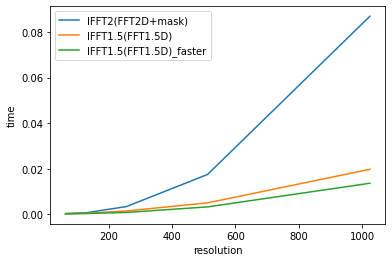

In [27]:
plt.plot(sizes[1:],times3[1:,0],label="IFFT2(FFT2D+mask)")
plt.plot(sizes[1:],times3[1:,1],label="IFFT1.5(FFT1.5D)")
plt.plot(sizes[1:],times3[1:,2],label="IFFT1.5(FFT1.5D)_faster")

plt.legend()
plt.xlabel('resolution')
plt.ylabel('time')